# Customer segmentation with clustering



This project applies clustering models to segment customers based on behavioural and value-based features.

The dataset contains sales transactions. Your goal is to segment customers using unsupervised learning, focusing on:

- Data cleaning and preprocessing
- Feature engineering at customer level
- Clustering models (K-Means, Hierarchical)
- Dimensionality reduction and 2D visualisation
- Interpretation of customer segments


# Import the libraries

In [ ]:
# Import the libraries

# Data manipulation
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Clustering
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Model evaluation
from sklearn.metrics import silhouette_score, silhouette_samples

# Import the data

In [ ]:
# import the data
df = pd.read_csv('https://github.com/FourthRevGitHub/CAM_DS_Public-Data-Sets/raw/main/Course%201/Week%206/CUSTOMERS_CLEAN.zip')

# Data preparation cell (re-runnable block)

This cell consolidates all key data cleaning and transformation steps below so that the notebook can be safely re-run from this point without errors or inconsistencies. **Comment out any code you do not wish to run at a given point.**

Note: To comment out multiple lines at one use `Ctrl + /`. Do the same to uncomment again.


In [ ]:
# --------------------
# Import the libraries
# --------------------

# Import the libraries

# Data manipulation
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Clustering
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE  # (for later)

# Model evaluation
from sklearn.metrics import silhouette_score, silhouette_samples

# -------------------
# Import the raw data
# -------------------

df = pd.read_csv('https://github.com/FourthRevGitHub/CAM_DS_Public-Data-Sets/raw/main/Course%201/Week%206/CUSTOMERS_CLEAN.zip')

# -----------------------------------
# Clean missing values and duplicates
# -----------------------------------

# Drop 'State_Province' and 'Postal_Code' columns
df.drop(columns=['State_Province', 'Postal_Code'], inplace=True)

# Drop rows where 'City' is missing
df = df[df['City'].notna()]

# Remove duplicates
df.drop_duplicates(inplace=True)

# ----------------------------------------
# Convert necessary columns to be numeric
# ----------------------------------------

# Convert 'Discount' column to float
df['Discount'] = df['Discount'].str.strip().replace('.', '0%')
df['Discount'] = df['Discount'].str.replace('%', '', regex=False).astype(float)

# Convert 'Total Revenue' column to float
df['Total Revenue'] = df['Total Revenue'].replace('[\$,]', '', regex=True).astype(float)

# Convert 'Unit Cost' column to float
df['Unit Cost'] = df['Unit Cost'].replace('[\$,]', '', regex=True).astype(float)

# Convert 'Profit' column to float
df['Profit'] = df['Profit'].replace('[\$,()]', '', regex=True)
df['Profit'] = df['Profit'].apply(lambda x: -float(x) if '(' in str(x) else float(x))

# ------------------------------------------
# Feature engineering (pre-aggregation)
# ------------------------------------------

# 'Recency'
df['Recency'] = (pd.to_datetime('today') - pd.to_datetime(df['Delivery_Date'], format='%d%b%Y')).dt.days

# 'CLV' = Total Revenue per row (summed per customer during aggregation)
df['CLV'] = df['Total Revenue']

# 'Age'
df['DOB'] = pd.to_datetime(df['Customer_BirthDate'], format='%d%b%Y')
today = pd.Timestamp('now')
df['Age'] = (today - df['DOB']).dt.days // 365

# ------------------------------------------
# Aggregation to one row per customer
# ------------------------------------------

# 'Frequency'
df['Frequency'] = df.groupby('Customer ID')['Order ID'].transform('count')

# Select columns
df_selected = df[['Customer ID', 'Frequency', 'Recency', 'CLV', 'Unit Cost', 'Age']].copy()

# Define aggregation logic
agg_operations = {
    'Frequency': 'max',
    'Recency': 'min',
    'CLV': 'sum',
    'Unit Cost': 'mean',
    'Age': 'max'
}

# Aggregate
df_aggr = df_selected.groupby('Customer ID').agg(agg_operations).reset_index()

# Rename column
df_aggr.rename(columns={'Unit Cost': 'Avg_Unit_Cost'}, inplace=True)

# ------------------------------------------
# Feature scaling (standardisation for clustering)
# ------------------------------------------

features_to_scale = ['Frequency', 'Recency', 'CLV', 'Avg_Unit_Cost', 'Age']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_aggr[features_to_scale])
X_scaled = pd.DataFrame(X_scaled, columns=features_to_scale)

# ------------------------------------------
# Final K-Means clustering (after scaling)
# ------------------------------------------
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_aggr['cluster'] = kmeans.fit_predict(X_scaled)

# -----------------------
# Final shape & view data
# -----------------------
print(df_aggr.shape)
print(df_aggr.head())

(68287, 7)
   Customer ID  Frequency  Recency      CLV  Avg_Unit_Cost  Age  cluster
0            1         35     3030  4322.70      89.622857   71        1
1            3         20     3132  2821.00      90.505000   41        2
2            4          9     4121   782.67      37.195556   41        0
3            5         19     3018  2810.98     107.947368   36        2
4            6         15     3203  1604.58      52.526667   66        3


# Initial data exploration and assessment

## View the DataFrame and metadata

In [ ]:
# View the dimensions of the dataset
print("Dataset shape:", df.shape)

# Display the first few rows to check it's loaded correctly
df.head()

Dataset shape: (951669, 20)


,Quantity,City,Continent,Postal_Code,State_Province,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
0,3,Leinster,Oceania,6437,Western Australia,01JAN2012,07JAN2012,$28.50,$9.10,.,Internet Sale,Australia,08MAY1978,Internet/Catalog Customers,Internet/Catalog Customers,1230000033,$1.20,6,99,8818
1,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$113.40,$56.90,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,($0.40),3,99,47793
2,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$41.00,$18.50,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,$4.00,3,99,47793
3,1,Northbridge,Oceania,2063,New South Wales,01JAN2012,03JAN2012,$35.20,$29.60,.,Internet Sale,Australia,22JUN1997,Orion Club Gold members,Orion Club Gold members high activity,1230000268,$5.60,2,0,71727
4,1,Montréal,North America,NaN,Quebec,01JAN2012,04JAN2012,$24.70,$23.60,.,Internet Sale,Canada,28JAN1978,Orion Club Gold members,Orion Club Gold members medium activity,1230000487,$1.10,3,99,74503


In [ ]:
# View the metadata with the info function.
df.info() # this does show missing values, but isnull().sum() is a bit easier to follow
# it shows the data types however, which is helpful.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951669 entries, 0 to 951668
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Quantity              951669 non-null  int64 
 1   City                  951534 non-null  object
 2   Continent             951669 non-null  object
 3   Postal_Code           947953 non-null  object
 4   State_Province        834477 non-null  object
 5   Order_Date            951669 non-null  object
 6   Delivery_Date         951669 non-null  object
 7   Total Revenue         951669 non-null  object
 8   Unit Cost             951669 non-null  object
 9   Discount              951669 non-null  object
 10  OrderTypeLabel        951669 non-null  object
 11  CustomerCountryLabel  951669 non-null  object
 12  Customer_BirthDate    951669 non-null  object
 13  Customer_Group        951669 non-null  object
 14  Customer_Type         951669 non-null  object
 15  Order ID         

## Check for missing values

Some columns like `Total Revenue`, `Unit Cost`, `Discount`, and `Profit` are stored as object types due to symbols such as `$` and brackets for negative values. Date columns use a custom format (e.g. `01JAN2012`) and need parsing into datetime. Although `info()` shows missing values, the following is a little easier to observe.


In [ ]:
# missing values
df.isnull().sum()

,0
Quantity,0
City,135
Continent,0
Postal_Code,3716
State_Province,117192
Order_Date,0
Delivery_Date,0
Total Revenue,0
Unit Cost,0
Discount,0


The columns `City`, `Postal_Code`, and `State_Province` contain missing values, with `State_Province` having a significant number (~117k). All other columns are complete. This will need to be considered during feature engineering and aggregation.

To address this, the `State_Province` and `Postal_Code` columns will be dropped due to the extent of missing data and limited relevance for segmentation. The small number of missing values in `City` (~135 rows) will be handled by removing those rows entirely.

In [ ]:
# Drop 'State_Province' and 'Postal_Code' columns
print("Before:", df.shape)
df.drop(columns=['State_Province', 'Postal_Code'], inplace=True)
print("After:", df.shape)

# Drop rows where 'City' is missing
print("Before:", df.shape)
df = df[df['City'].notna()]
print("After:", df.shape)


Before: (951669, 20)
After: (951669, 18)
Before: (951669, 18)
After: (951534, 18)


## Check for duplicate values

In [ ]:
# Checking for duplicate values (after missing values are dealt with)
duplicate_rows = df.duplicated().sum()
print("Number of Duplicate Rows:", duplicate_rows)
#df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).shape
df[df.duplicated(keep=False)].sort_values(by=list(df.columns))

Number of Duplicate Rows: 21


,Quantity,City,Continent,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
374958,1,Birmingham,Europe,11MAR2014,11MAR2014,$23.80,$21.30,.,Retail Sale,United Kingdom,28DEC1978,Orion Club Gold members,Orion Club Gold members medium activity,1235142105,$2.50,0,0,12304
374959,1,Birmingham,Europe,11MAR2014,11MAR2014,$23.80,$21.30,.,Retail Sale,United Kingdom,28DEC1978,Orion Club Gold members,Orion Club Gold members medium activity,1235142105,$2.50,0,0,12304
337840,1,Cambridge City,North America,04JAN2014,04JAN2014,$26.99,$20.46,.,Retail Sale,United States,27NOV1978,Orion Club Gold members,Orion Club Gold members high activity,1234463495,$6.53,0,0,31754
337841,1,Cambridge City,North America,04JAN2014,04JAN2014,$26.99,$20.46,.,Retail Sale,United States,27NOV1978,Orion Club Gold members,Orion Club Gold members high activity,1234463495,$6.53,0,0,31754
303246,1,Cheadle,Europe,26OCT2013,26OCT2013,$37.40,$32.60,.,Retail Sale,United Kingdom,04DEC1963,Orion Club members,Orion Club members low activity,1233990855,$4.80,0,99,6707
303247,1,Cheadle,Europe,26OCT2013,26OCT2013,$37.40,$32.60,.,Retail Sale,United Kingdom,04DEC1963,Orion Club members,Orion Club members low activity,1233990855,$4.80,0,99,6707
754743,1,Kelsterbach,Europe,05FEB2016,05FEB2016,$26.99,$20.46,.,Retail Sale,Germany,17JAN1973,Orion Club members,Orion Club members high activity,1241354674,$6.53,0,99,48984
754744,1,Kelsterbach,Europe,05FEB2016,05FEB2016,$26.99,$20.46,.,Retail Sale,Germany,17JAN1973,Orion Club members,Orion Club members high activity,1241354674,$6.53,0,99,48984
25808,1,Köln,Europe,08MAR2012,08MAR2012,$59.70,$59.90,.,Retail Sale,Germany,15MAR1958,Orion Club members,Orion Club members medium activity,1230368036,($0.20),0,99,29993
25809,1,Köln,Europe,08MAR2012,08MAR2012,$59.70,$59.90,.,Retail Sale,Germany,15MAR1958,Orion Club members,Orion Club members medium activity,1230368036,($0.20),0,99,29993


We will now remove these duplicates.

In [ ]:
print("Before:", df.shape)
df.drop_duplicates(inplace=True)
print("After:", df.shape)

Before: (951534, 18)
After: (951513, 18)


## Exploratory data analysis (EDA)

With nearly a million rows, standard EDA has limited value for gaining meaningful insights, so histograms will not be explored. However, boxplots will be considered for numerical columns, including those that should be numeric but require cleaning first.


### Clean numeric columns for EDA

The following columns need cleaning before they can be treated as numeric:

| Column           | Issue                                           | Required Action                         |
|------------------|--------------------------------------------------|------------------------------------------|
| Total Revenue     | Contains dollar signs (`$`)                    | Remove symbol and convert to float       |
| Unit Cost         | Contains dollar signs (`$`)                    | Remove symbol and convert to float       |
| Discount          | Contains `.` instead of numeric values         | Investigate or impute; convert to float  |
| Profit            | Contains `$` and negative values in brackets   | Clean symbols/brackets and convert to float |

#### `Discount` column

In [ ]:
# Check unique values and their counts
print(df['Discount'].value_counts(dropna=False).head(10))


Discount
   .    942361
30%       3948
40%       3034
50%       1961
60%        209
Name: count, dtype: int64


The `Discount` column contains the value `.` for the vast majority of rows, with a small number of valid percentage values such as `30%`, `40%`, and `50%`. It is reasonable to treat `.` as representing a `0%` discount.

This interpretation is confirmed by inspecting rows where `Discount` is `.`. For example, consider the row with `Order ID` `1230000033`:

```
Quantity: 3
Unit Cost: $9.10  
Profit: $1.20
Total Revenue: $28.50
```

Using the formula:
```
Total Revenue = (Quantity × Unit Cost) + Profit
              = (3 × 9.10) + 1.20
              = 27.30 + 1.20
              = 28.50
```

This confirms that no discount was applied. Therefore, we will interpolate `.` as `0%`, convert all values to floats, and proceed with further analysis.

In [ ]:
# Only clean the column if it's still of type 'object' (i.e. string),
# so the code can be safely run multiple times without causing errors
if df['Discount'].dtype == 'object':
    # Strip whitespace and replace '.' with '0%'
    # Step-by-step explanation:
    # df['Discount'] accesses the 'Discount' column from the DataFrame.
    # .str gives access to string methods for each element in the column.
    # .strip() removes any leading or trailing whitespace characters from each string (e.g. spaces, tabs, newlines).
    # This ensures that values like '   .' become '.' so they can be matched correctly in the next step.
    # .replace('.', '0%') replaces any string that is exactly '.' with the string '0%'.
    # This accounts for entries where a missing discount was recorded as '.' and we treat it as 0%.
    df['Discount'] = df['Discount'].str.strip().replace('.', '0%')

    # Remove the '%' symbol and convert the result to float so it's usable in numerical analysis
    df['Discount'] = df['Discount'].str.replace('%', '', regex=False).astype(float)
# End 'if'

# Confirm the column has been successfully converted to float
print(df['Discount'].dtype)
#df['Discount'].head() # a bit dull here
print(df['Discount'].value_counts().sort_index())


float64
Discount
0.0     942361
30.0      3948
40.0      3034
50.0      1961
60.0       209
Name: count, dtype: int64


#### `Total Revenue`, `Unit Cost`, `Profit` columns

First `Total Revenue`:

In [ ]:
# Remove dollar signs and convert 'Total Revenue' column to float
# Step-by-step explanation:
# df['Total Revenue'] accesses the column in the DataFrame.
# .replace('[\$,]', '', regex=True) uses a regular expression to:
#   - Find and remove any dollar signs ($) or commas (,) from the strings.
#   - [\$,] is a character set: it matches either '$' or ','.
#   - The backslash \ escapes the dollar sign, which is a special character in regex (it normally means "end of line").
#   - The comma does not need escaping because it has no special meaning in this context.
# .astype(float) converts the cleaned strings to float type for numerical analysis.
df['Total Revenue'] = df['Total Revenue'].replace('[\$,]', '', regex=True).astype(float)

Next `Unit Cost`:

In [ ]:
df['Unit Cost'] = df['Unit Cost'].replace('[\$,]', '', regex=True).astype(float)

Next `Profit`, the first part is the same idea as seen above, dealing with positive numbers:

In [ ]:
# First, remove unwanted characters from the string
# .replace('[\$,()]', '', regex=True) removes:
#   - Dollar signs ($)
#   - Commas (if present, though not explicitly here)
#   - Opening and closing brackets: '(' and ')'
# The brackets are important because negative values are sometimes written like this: '($1.20)'
df['Profit'] = df['Profit'].replace('[\$,()]', '', regex=True)

Then we need to deal with the negative numbers by interpreting the brackets (parentheses):

In [ ]:
# Now convert cleaned strings to float, preserving the original sign
# .apply(lambda x: ...) applies a function to each value — here named 'x' — in the column
# Inside the lambda:
#   - str(x) ensures we're working with a string (in case it's not already)
#   - If the original string had '(', it means the profit was negative
#   - So we multiply the float by -1 to preserve the negative value
#     (e.g. '($1.20)' becomes '1.20' after cleaning, and -float(x) turns it back to -1.20)
#   - Otherwise, just convert x to float normally
df['Profit'] = df['Profit'].apply(lambda x: -float(x) if '(' in str(x) else float(x))

Check the columns:

In [ ]:
# Check that values are numeric and look reasonable
print("Total Revenue:", df['Total Revenue'].describe())
print("\nUnit Cost:", df['Unit Cost'].describe())
print("\nProfit:", df['Profit'].describe())


Total Revenue: count    951513.000000
mean        139.963339
std         185.736619
min           0.630000
25%          39.800000
50%          84.100000
75%         171.300000
max        9385.800000
Name: Total Revenue, dtype: float64

Unit Cost: count    951513.000000
mean         77.757511
std          85.278587
min           0.400000
25%          26.300000
50%          50.500000
75%          99.000000
max        1583.600000
Name: Unit Cost, dtype: float64

Profit: count    951513.000000
mean         13.437030
std          31.784781
min           0.000000
25%           1.000000
50%           5.200000
75%          13.200000
max        2121.600000
Name: Profit, dtype: float64


### Boxplots for numerical features

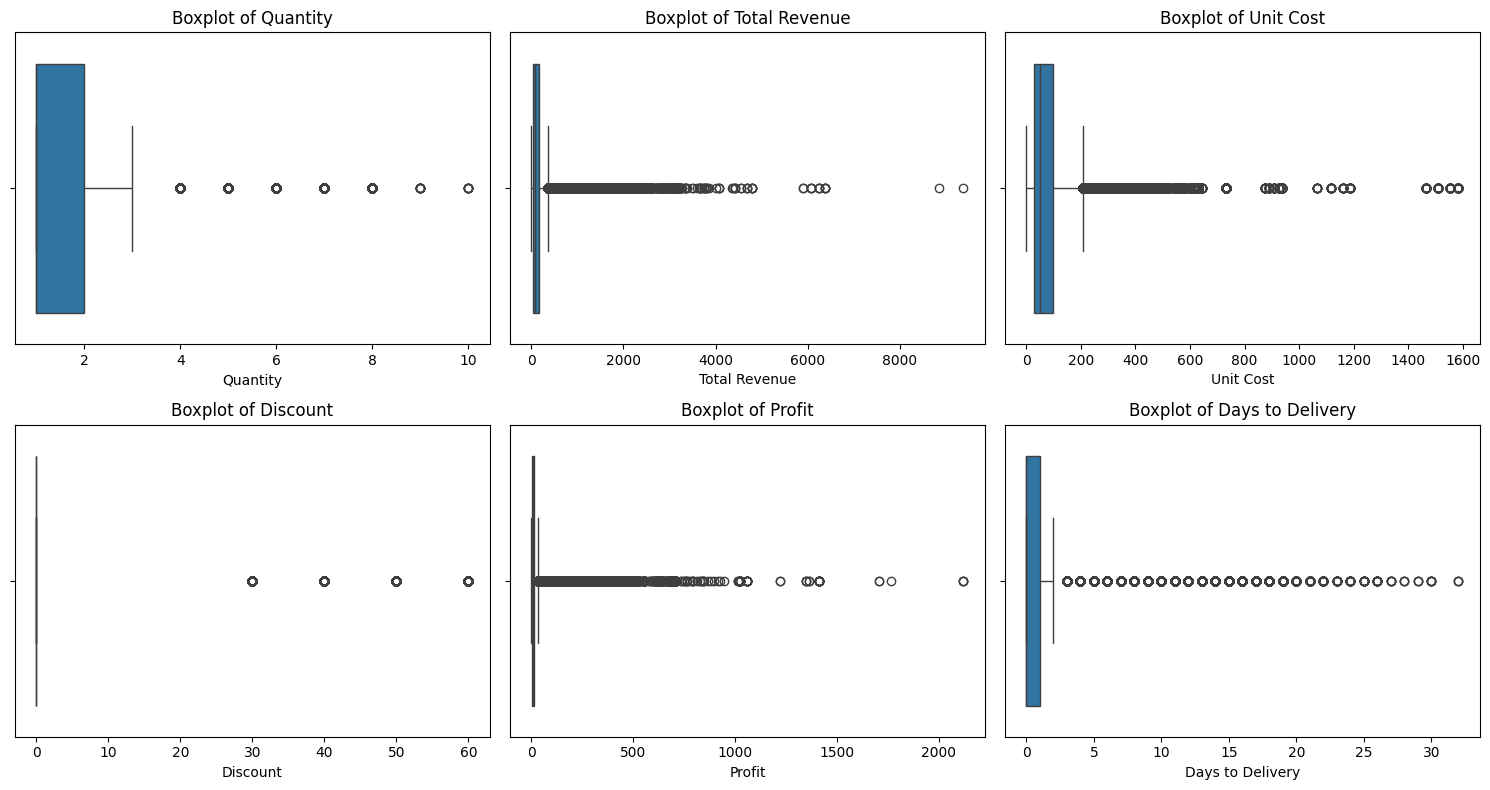

In [ ]:
#import matplotlib.pyplot as plt
#import seaborn as sns

numeric_cols = ['Quantity', 'Total Revenue', 'Unit Cost', 'Discount', 'Profit', 'Days to Delivery']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()


The boxplots confirm significant skew across several numerical features, particularly `Total Revenue`, `Unit Cost`, and `Profit`, with many extreme outliers. Due to the scale of the data, the plots are visually limited, but they clearly indicate the presence of skewness and outliers. These findings will inform the next stage of outlier detection.

## Outlier detection

To go beyond visual inspection with boxplots, we applied the IQR method to statistically flag outliers and create binary indicators for each numerical feature.

In [ ]:
numeric_cols = ['Quantity', 'Total Revenue', 'Unit Cost', 'Discount', 'Profit', 'Days to Delivery']

outlier_summary = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Add binary outlier column
    outlier_col = f'{col}_outlier'
    df[outlier_col] = ((df[col] < lower) | (df[col] > upper)).astype(int)

    # Calculate outlier stats
    outlier_count = df[outlier_col].sum()
    total = len(df)
    outlier_pct = (outlier_count / total) * 100
    within_range = "Yes" if 1 <= outlier_pct <= 5 else "No"

    outlier_summary.append([col, outlier_count, total - outlier_count, outlier_pct, within_range])

# Display summary as DataFrame
import pandas as pd
outlier_df = pd.DataFrame(outlier_summary, columns=[
    'Feature', 'Outlier Count', 'Normal Count', 'Outlier %', 'Within 1–5%?'
])

outlier_df

,Feature,Outlier Count,Normal Count,Outlier %,Within 1–5%?
0,Quantity,44113,907400,4.636090,Yes
1,Total Revenue,68505,883008,7.199586,No
2,Unit Cost,64096,887417,6.736219,No
3,Discount,9152,942361,0.961837,No
4,Profit,91664,859849,9.633499,No
5,Days to Delivery,180721,770792,18.993014,No


Outliers were formally detected using the IQR method across the six cleaned numerical features. For each feature, we calculated the first (Q1) and third (Q3) quartiles and identified values falling outside the range [Q1 - 1.5×IQR, Q3 + 1.5×IQR] as outliers. A binary column was created for each feature to flag outlier instances.

The percentage of outliers varied substantially across features. Only `Quantity` fell within the commonly cited 1-5% range for acceptable outliers. Other features, such as `Profit`, `Total Revenue`, and `Unit Cost`, had outlier percentages exceeding 6%, while `Days to Delivery` exhibited an especially high proportion of outliers at nearly 19%. **Although the 1-5% range is not a strict rule, it serves as a helpful benchmark to assess the distribution of data.**

Given the scale and nature of the data, we decided not to remove outliers at this stage. Outliers may represent meaningful business phenomena—such as bulk purchases or delayed deliveries—rather than data errors. Removing them could result in the loss of valuable information, especially in a customer segmentation task where such extremes may define key behavioural patterns. Instead, we retain the binary flags for each feature to preserve flexibility in downstream analysis.

## Feature engineering

The goal is to generate five customer-level features to support segmentation: `Frequency`, `Recency`, `Customer Lifetime Value (CLV)`, `Average Unit Cost`, and `Customer Age`. These capture key behavioural and value-based patterns relevant to clustering.

Some of these features depend on row-level details (e.g. delivery dates, birthdates), while others are best calculated during aggregation. The table below clarifies which are best handled before or during aggregation.

| Feature           | Best calculated pre-aggregation? | Best calculated during aggregation? | Reason                                |
|------------------|----------------------------------|--------------------------------------|----------------------------------------|
| Frequency         | ❌                              | ✅                                   | Count of orders per customer           |
| Recency           | ✅                              | ❌                                   | Needs row-level delivery dates         |
| CLV               | ✅ (from Total Revenue)         | ✅ (sum per customer)                | Requires cleaning before aggregation, then summed during aggregation |
| Avg Unit Cost     | ❌                              | ✅                                   | Requires average over multiple orders  |
| Age               | ✅                              | ❌                                   | Based on fixed birthdate per row       |

### Pre-aggregation features

The following features require row-level information and must be calculated before aggregating the dataset to one row per customer.

#### Recency

Recency captures how long it has been since a customer's last order, which can signal engagement or churn risk.

**Note:** We assume that the Delivery_Date column follows the format `'%d%b%Y'` (e.g. `01JAN2012`) and apply this format when parsing dates. If this assumption proves incorrect, the code will raise an error, and the format can be reevaluated accordingly.

In [ ]:
# Calculate 'Recency' as the number of days since the last delivery for each order
df['Recency'] = (pd.to_datetime('today') - pd.to_datetime(df['Delivery_Date'], format='%d%b%Y')).dt.days

# Confirm it's numeric
print(df['Recency'].dtype)

# Check basic stats to see if values are reasonable
df['Recency'].describe()


int64


,Recency
count,951513.000000
mean,3874.977195
std,519.778500
min,2993.000000
25%,3420.000000
50%,3877.000000
75%,4310.000000
max,4837.000000


#### Customer lifetime value (CLV)

CLV estimates how much revenue a customer has generated overall — useful for identifying high-value customers.

In [ ]:
# Copy to new column and drop the original
df['CLV'] = df['Total Revenue']
#df.drop(columns='Total Revenue', inplace=True)

# Alternatively you can do this in one line by renaming the column like this:
#df.rename(columns={'Total Revenue': 'CLV'}, inplace=True)

# Confirm it's numeric
print(df['CLV'].dtype)

# Check basic stats to see if values are reasonable
df['CLV'].describe()

float64


,CLV
count,951513.000000
mean,139.963339
std,185.736619
min,0.630000
25%,39.800000
50%,84.100000
75%,171.300000
max,9385.800000


#### Customer age

Customer age is derived from birthdate and may reveal patterns across age groups in purchasing behaviour.

In [ ]:
# Convert 'Customer_BirthDate' to datetime, then calculate age in years
df['DOB'] = pd.to_datetime(df['Customer_BirthDate'], format='%d%b%Y')
today = pd.Timestamp('now')
df['Age'] = (today - df['DOB']).dt.days // 365

# Confirm it's numeric
print(df['Age'].dtype)

# Sanity check: realistic age range
df['Age'].describe()

int64


,Age
count,951513.000000
mean,49.194713
std,16.384895
min,27.000000
25%,32.000000
50%,47.000000
75%,62.000000
max,82.000000


### Aggregate the data to one row per customer

To prepare the data for clustering, we aggregate the dataset so that each customer is represented by a single row. This finalises the customer-level features required for segmentation.

We begin by creating the `Frequency` feature before reducing the DataFrame.

In [ ]:
# OPTIONAL: Preview multiple orders for a single customer
# This confirms what Frequency will be counting
multi_orders = df['Customer ID'].value_counts()
customer_with_many_orders = multi_orders[multi_orders > 1].index[0]

# View rows for that customer
df[df['Customer ID'] == customer_with_many_orders]

,Quantity,City,Continent,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,...,Quantity_outlier,Total Revenue_outlier,Unit Cost_outlier,Discount_outlier,Profit_outlier,Days to Delivery_outlier,Recency,CLV,DOB,Age
17033,1,Reggio Emilia Re,Europe,12FEB2012,12FEB2012,25.3,21.9,0.0,Retail Sale,Italy,...,0,0,0,0,0,0,4796,25.3,1973-09-25,51
17034,1,Reggio Emilia Re,Europe,12FEB2012,12FEB2012,328.3,331.9,0.0,Retail Sale,Italy,...,0,0,1,0,0,0,4796,328.3,1973-09-25,51
26806,1,Reggio Emilia Re,Europe,10MAR2012,10MAR2012,12.1,11.9,0.0,Retail Sale,Italy,...,0,0,0,0,0,0,4769,12.1,1973-09-25,51
62237,1,Reggio Emilia Re,Europe,29MAY2012,29MAY2012,190.2,166.6,0.0,Retail Sale,Italy,...,0,0,0,0,0,0,4689,190.2,1973-09-25,51
62238,1,Reggio Emilia Re,Europe,29MAY2012,29MAY2012,45.0,41.1,0.0,Retail Sale,Italy,...,0,0,0,0,0,0,4689,45.0,1973-09-25,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784443,1,Reggio Emilia Re,Europe,06APR2016,06APR2016,28.0,25.1,0.0,Retail Sale,Italy,...,0,0,0,0,0,0,3281,28.0,1973-09-25,51
784444,2,Reggio Emilia Re,Europe,06APR2016,06APR2016,174.4,87.4,0.0,Retail Sale,Italy,...,0,0,0,0,0,0,3281,174.4,1973-09-25,51
851268,2,Reggio Emilia Re,Europe,23JUL2016,26JUL2016,315.6,158.0,0.0,Retail Sale,Italy,...,0,0,0,0,0,1,3170,315.6,1973-09-25,51
909184,1,Reggio Emilia Re,Europe,31OCT2016,31OCT2016,70.8,59.6,0.0,Retail Sale,Italy,...,0,0,0,0,0,0,3073,70.8,1973-09-25,51


In [ ]:
# Step 1: Create 'Frequency' as the number of orders per customer
df['Frequency'] = df.groupby('Customer ID')['Order ID'].transform('count')

# Check the data type and basic stats
print(df['Frequency'].dtype)
df['Frequency'].describe()

int64


,Frequency
count,951513.000000
mean,23.143912
std,14.922080
min,1.000000
25%,13.000000
50%,20.000000
75%,30.000000
max,121.000000


Next, we create a temporary DataFrame containing only the columns required for aggregation.

In [ ]:
# Step 2: Select relevant columns for aggregation
df_selected = df[['Customer ID', 'Frequency', 'Recency', 'CLV', 'Unit Cost', 'Age']].copy()


We define the aggregation logic to summarise each customer’s data. For `Frequency` and `Age`, the values are constant per customer, so any reduction (e.g. `max`) will suffice. `CLV` and `Avg_Unit_Cost` are true aggregations.

In [ ]:
# Step 3: Define aggregation logic
agg_operations = {
    'Frequency': 'max',
    'Recency': 'min',
    'CLV': 'sum',
    'Unit Cost': 'mean',
    'Age': 'max'
}

In [ ]:
# Step 4: Aggregate to one row per customer
df_aggr = df_selected.groupby('Customer ID').agg(agg_operations).reset_index()

# Step 5: Rename column
df_aggr.rename(columns={'Unit Cost': 'Avg_Unit_Cost'}, inplace=True)

# # Step 6: Drop Customer ID (not needed for unsupervised learning)
# df_aggr.drop(columns='Customer ID', inplace=True)

# Check shape
print(df_aggr.shape)
# Check first 5 rows
print(df_aggr.head())

(68287, 6)
   Customer ID  Frequency  Recency      CLV  Avg_Unit_Cost  Age
0            1         35     3030  4322.70      89.622857   71
1            3         20     3132  2821.00      90.505000   41
2            4          9     4121   782.67      37.195556   41
3            5         19     3018  2810.98     107.947368   36
4            6         15     3203  1604.58      52.526667   66


At this stage, each customer is represented by a single row containing the five engineered features required for clustering: Frequency, Recency, CLV, Avg_Unit_Cost, and Age. The dataset is now ready for further preprocessing and modelling.

### Feature scaling

Clustering algorithms such as K-Means and Hierarchical Clustering rely on distance metrics, making them sensitive to the scale of the input features. To ensure each feature contributes equally to the distance calculations, we apply standardisation using StandardScaler.

Standardisation is generally preferred over normalisation in this context because the features vary in scale, are not naturally bounded, and may contain outliers. Methods like K-Means also perform better when data is centred and normally distributed, making standardisation the more robust choice for clustering.

**Feature encoding** is not required in this case, as all features in the final dataset are numeric. Categorical variables were excluded during earlier preprocessing.

In [ ]:
#from sklearn.preprocessing import StandardScaler

# Select features to scale (drop Customer ID if still present)
features_to_scale = ['Frequency', 'Recency', 'CLV', 'Avg_Unit_Cost', 'Age']

# Initialise scaler
scaler = StandardScaler()

# Apply scaling
X_scaled = scaler.fit_transform(df_aggr[features_to_scale])

# Convert back to DataFrame in order to inspect or label columns
X_scaled = pd.DataFrame(X_scaled, columns=features_to_scale)

# Check the shape & first 5 rows:
print(X_scaled.shape)
print(X_scaled.head())


(68287, 5)
   Frequency   Recency       CLV  Avg_Unit_Cost       Age
0   1.859585 -0.843350  1.379420       0.282194  1.120747
1   0.535470 -0.597141  0.506281       0.305404 -0.594272
2  -0.435548  1.790128 -0.678872      -1.097238 -0.594272
3   0.447195 -0.872316  0.500455       0.764336 -0.880109
4   0.094098 -0.425759 -0.200986      -0.693856  0.834910


Exploratory analysis and **visual checks** were performed earlier during outlier detection. As scaling is a preprocessing step rather than part of exploration, we do not visualise the transformed features here.

While tools like **pipelines and column transformers** offer a more modular approach to processing, they were not necessary in this workflow. The current approach provides greater transparency and control, which is useful during development and interpretation.

# Clustering with ML models

## Elbow method

To estimate the optimal number of clusters, we apply the Elbow method by fitting K-Means with varying values of k and plotting the resulting within-cluster sum of squares (WCSS). The point where the curve starts to level off indicates a suitable number of clusters.

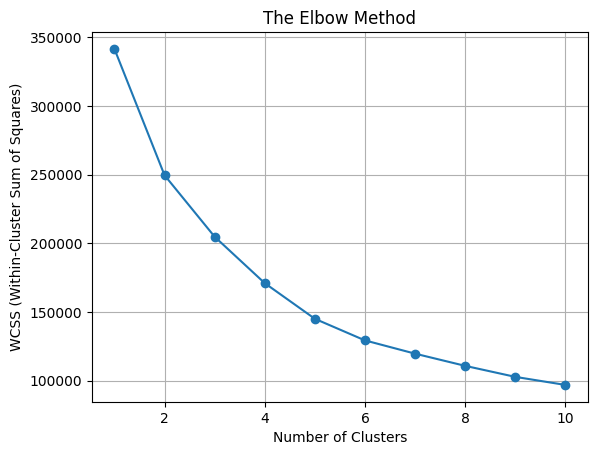

In [ ]:
#from sklearn.cluster import KMeans
#import matplotlib.pyplot as plt

# Elbow method using scaled data
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()


The Elbow curve does not reveal a sharp 'knee' point but instead shows a gradual flattening. There is a significant drop in WCSS from *k = 1* to *k = 3*, followed by a more modest decline from *k = 4* onwards. After *k = 6*, the rate of improvement becomes minimal.

Based on this trend, *k = 4* appears to strike a balance between model simplicity and cluster separation. It is not a definitive answer, but a reasonable estimate that can be cross-validated with other methods such as the Silhouette score and Hierarchical clustering.

## Silhouette score

The silhouette score measures how well each data point fits within its assigned cluster, compared to other clusters. It ranges from -1 to 1, where higher values indicate better-defined clusters. This method provides another perspective on selecting the optimal number of clusters.

We use two functions from `sklearn.metrics` to support this analysis:

* `silhouette_score()` calculates a **single average score** across all data points. This helps us compare clustering performance across different values of k and identify which number of clusters best separates the data.

* `silhouette_samples()` calculates an **individual silhouette score for each data point**, which can later be used for detailed visualisation (e.g. silhouette plots) or deeper analysis of how well each point fits into its assigned cluster.

In [ ]:
#from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avgs = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    # 4 decimal points seems reasonable for interpretability, whereas the default 16 is excessive.
    print(f"For n_clusters = {n_clusters}, silhouette score = {silhouette_avg:.4f}")

    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

For n_clusters = 2, silhouette score = 0.2603
For n_clusters = 3, silhouette score = 0.2527
For n_clusters = 4, silhouette score = 0.2532
For n_clusters = 5, silhouette score = 0.2670
For n_clusters = 6, silhouette score = 0.2525


The highest score was observed at k = 5, indicating this configuration offered the best-defined clusters according to this method. However, the differences across k values are minimal, **suggesting that the data does not have a strongly natural clustering structure**.

In cases like this, choosing the number of clusters may depend more on practical interpretability and alignment with business objectives. k = 4 remains a reasonable alternative — especially as it was supported by the Elbow method. Further validation using hierarchical clustering will help confirm the best choice.

## Hierarchical clustering

Hierarchical clustering builds a nested tree of clusters by successively merging or splitting groups based on their similarity. We use agglomerative clustering and a dendrogram to help identify a suitable number of clusters by looking for natural divisions in the tree.

Since running the clustering on the full dataset (~68,000 customers) was too computationally intensive, we used a random sample of 500 customers to make the analysis tractable. The dendrogram was also truncated to display only the final 10 merged clusters, keeping the plot readable while still revealing the underlying structure.

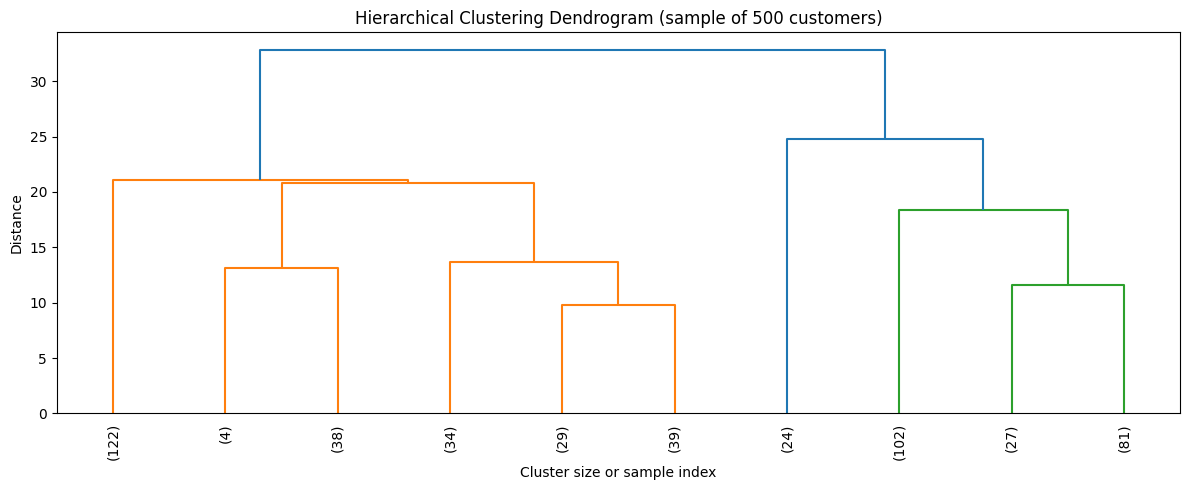

In [ ]:
# from scipy.spatial.distance import pdist
# from scipy.cluster.hierarchy import linkage, dendrogram
# import matplotlib.pyplot as plt

# Take a smaller sample for dendrogram plotting
sample_df = df_aggr.sample(n=500, random_state=42).reset_index(drop=True)

# Scale again for the sample
X_sample = scaler.fit_transform(sample_df[features_to_scale])

# Compute linkage
linkage_matrix = linkage(pdist(X_sample), method='ward')

# Plot truncated dendrogram
plt.figure(figsize=(12, 5))
dendrogram(linkage_matrix, truncate_mode='lastp', p=10, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram (sample of 500 customers)")
plt.xlabel("Cluster size or sample index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

The dendrogram reveals several large vertical distances between cluster merges, indicating well-separated groups. By drawing a horizontal line at approximately height 22-25 on the plot, the tree is naturally split into four major branches before larger merges occur. This suggests that four clusters is a sensible choice based on the hierarchical structure of the data.

This aligns well with the result from the Elbow method and is close to the silhouette score outcome, providing a strong case for selecting k = 4 as the final number of clusters.

## Final selection of optimal number of clusters

All three methods provided insight into the optimal number of clusters. The Elbow method showed a noticeable inflection around k = 4, while the silhouette score was highest for k = 5, though only marginally. The dendrogram from hierarchical clustering supported k = 4 as a natural split in the data.

Taken together, **k = 4 is selected as the final number of clusters for segmentation**. It balances model simplicity with clear group separation and is supported by multiple independent methods.

## K-Means clustering (final model with k=4)

Now that the optimal number of clusters has been selected, we perform the final K-Means clustering on the scaled customer features. Each customer is assigned to one of the **four clusters**, creating a new column that captures their segment label.

In [ ]:
#from sklearn.cluster import KMeans

# Perform final K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_aggr['cluster'] = kmeans.fit_predict(X_scaled)

# View updated DataFrame
print("View updated DataFrame with new cluster column:")
print(df_aggr.head())

# Extract final cluster centres
centroids = kmeans.cluster_centers_

# Print final centroids
print("Final Centroids (in scaled space):")
print(centroids)

View updated DataFrame with new cluster column:
   Customer ID  Frequency  Recency      CLV  Avg_Unit_Cost  Age  cluster
0            1         35     3030  4322.70      89.622857   71        1
1            3         20     3132  2821.00      90.505000   41        2
2            4          9     4121   782.67      37.195556   41        0
3            5         19     3018  2810.98     107.947368   36        2
4            6         15     3203  1604.58      52.526667   66        3
Final Centroids (in scaled space):
[[-0.79393791  1.80789147 -0.73540611  0.02065006  0.25234603]
 [ 1.67614028 -0.5911224   1.70003916  0.11375607 -0.24581215]
 [-0.1655266  -0.31121742 -0.18229123  0.01425227 -0.86102819]
 [-0.28715118 -0.32833539 -0.31365869 -0.08885126  0.95212627]]


The resulting cluster labels were stored in a new column, and the centroids were extracted for potential interpretation. This completes the clustering phase and prepares the data for cluster-level analysis.

# Customer Segments

With clustering complete, we now explore how the segmentation divides the customer base. This begins with a quick view of how customers are assigned to clusters, followed by visual analysis of the feature distributions within each group.

In [ ]:
# Display cluster assignment for each customer
df_aggr[['Customer ID', 'cluster']].head(10)

,Customer ID,cluster
0,1,1
1,3,2
2,4,0
3,5,2
4,6,3
5,7,1
6,9,1
7,10,1
8,11,2
9,12,2


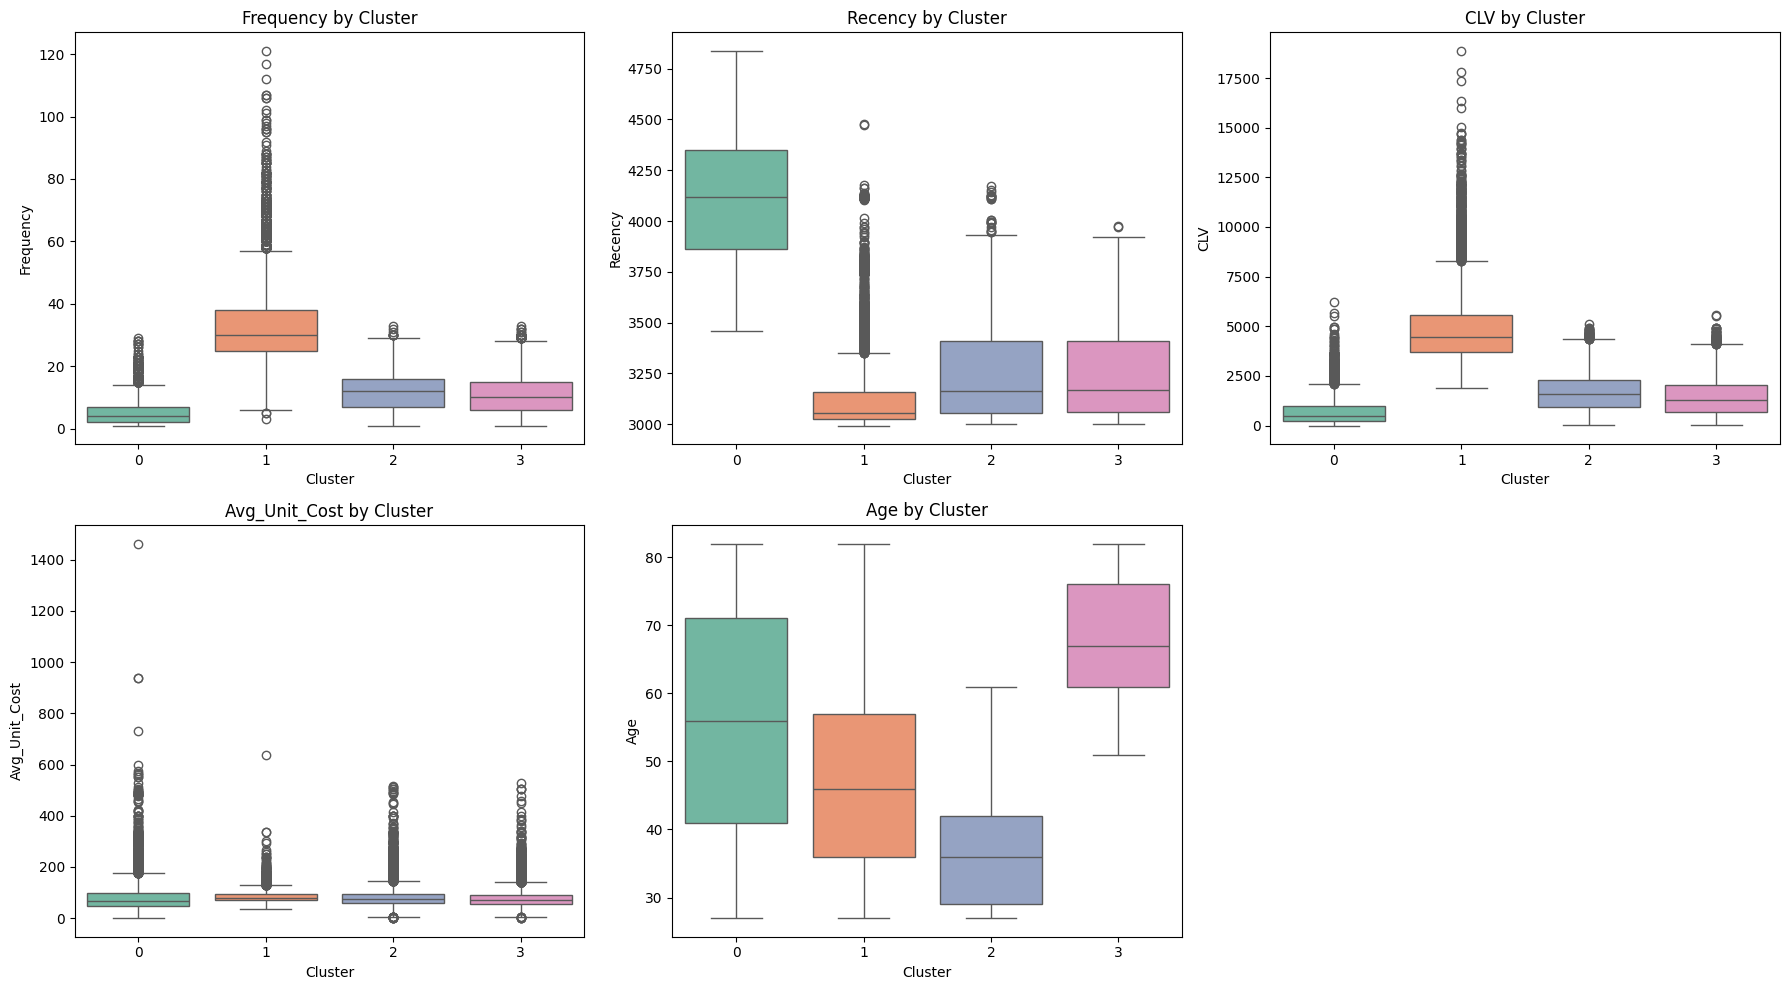

In [ ]:
# Import required libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# List of final features we want to analyse across clusters
features = ['Frequency', 'Recency', 'CLV', 'Avg_Unit_Cost', 'Age']

# Set up a grid of 2 rows × 3 columns of subplots
# figsize defines how large the overall figure should be
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Flatten the 2D list of axes (from subplots) into a 1D list for easy looping
axes = axes.flatten()

# Loop through each feature and its subplot index
for i, feature in enumerate(features):

    # Create a boxplot for the given feature grouped by 'cluster'
    # - data: the DataFrame we're using
    # - x: the categorical variable (cluster)
    # - y: the numeric variable we're plotting
    # - hue='cluster': gives each cluster a distinct colour (optional since x is also cluster)
    # - ax=axes[i]: draw the plot in the correct subplot
    # - palette='Set2': use a nice preset colour scheme
    # - legend=False: suppress redundant legend on each plot
    sns.boxplot(data=df_aggr,
                x='cluster',
                y=feature,
                hue='cluster',
                ax=axes[i],
                palette='Set2',
                legend=False)

    # Set plot title and axis labels
    axes[i].set_title(f'{feature} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

# There are 6 subplots, but only 5 features.
# This deletes the last empty subplot to keep things tidy
fig.delaxes(axes[-1])

# Make sure everything fits without overlap
plt.tight_layout()

# Show the full figure with all plots
plt.show()


The boxplots below illustrate how each cluster differs across the five engineered features: Frequency, Recency, Customer Lifetime Value (CLV), Average Unit Cost, and Age. These visual comparisons help to understand the behavioural characteristics and potential value of each customer segment.

**Cluster 0** represents moderately active customers. Their frequency and CLV are average relative to the other groups, with a slightly lower age profile. Recency is reasonably low, suggesting these customers are still engaged but not particularly high spenders. They may be regular but low-value buyers or customers with occasional purchases that maintain recent contact.

**Cluster 1** stands out clearly as the highest-value segment. These customers order frequently and spend significantly more than the others, reflected in their high CLV and frequency. Their recency is the lowest among all groups, suggesting recent engagement. This group is a strong candidate for loyalty programmes or premium targeting, as they represent the most profitable and active customer base.

**Cluster 2** shows similarities to Cluster 0 in terms of recency and age, but has slightly lower frequency and CLV. This group could represent less engaged but not yet dormant customers. With targeted campaigns, they may be encouraged to increase their activity or spending.

**Cluster 3** appears to be the most disengaged segment. Customers in this group show very low frequency and CLV, combined with the highest recency — indicating long periods since their last purchase. They are also older, on average, suggesting this may be a long-standing group that has since lapsed. These customers could be at risk of churn and may not respond well to broad marketing efforts.

Taken together, these clusters represent distinct behavioural profiles across the customer base. The contrast between Clusters 1 and 3 is particularly strong, revealing a clear divide between high-value, recently active customers and older, disengaged ones. Clusters 0 and 2 sit in between and may benefit from tailored strategies to increase either frequency or overall spend. This segmentation provides a foundation for more personalised and efficient marketing interventions.

# Dimensionality reduction and 2D visualisation

Dimensionality reduction helps simplify complex, multi-feature datasets by projecting them into lower-dimensional spaces while retaining the most relevant patterns. This is especially useful for visualising clusters in two dimensions. In this section, both **Principal Component Analysis (PCA)** and **t-distributed Stochastic Neighbour Embedding (t-SNE)** are applied to the scaled dataset to visualise customer segmentation. These visualisations provide intuitive insight into how well-separated the clusters are in lower-dimensional space.

## PCA visualisation

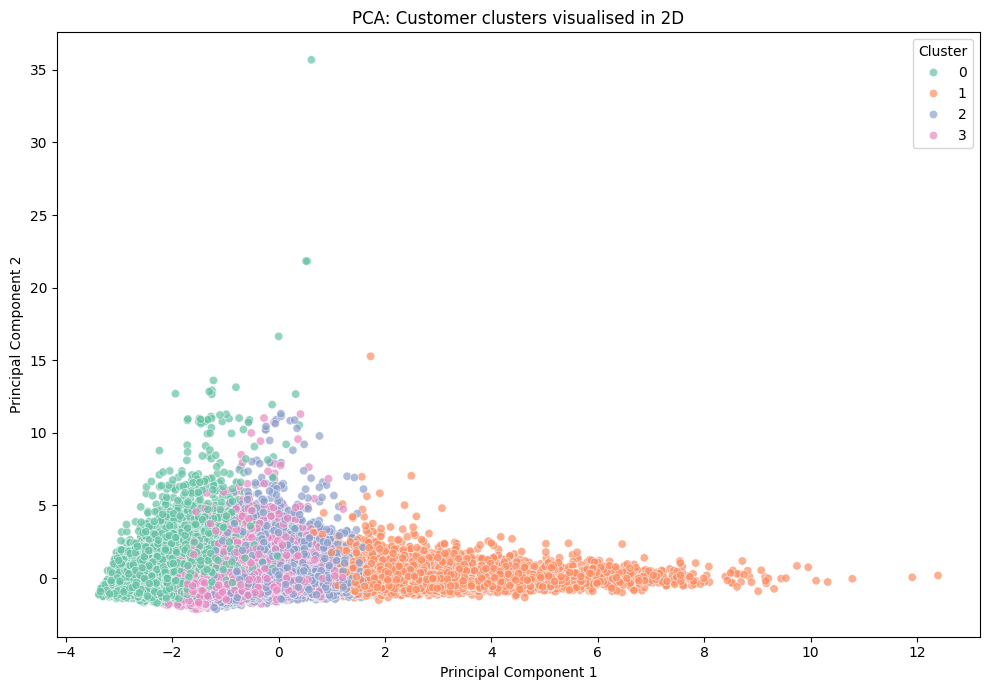

In [ ]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import seaborn as sns

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = df_aggr['cluster']

# Plot the PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2', alpha=0.7)
plt.title('PCA: Customer clusters visualised in 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

The PCA visualisation shows that Cluster 1 stands out clearly along the first principal component, indicating that its customers are significantly different — likely due to their high frequency and CLV, as seen in the boxplots. However, the remaining clusters (0, 2, and 3) are heavily overlapping, making it difficult to distinguish them in two dimensions.

This suggests that PCA, being a linear technique, may not fully capture the more complex, non-linear patterns in the data. While it is useful for identifying broad separations, it may not be sufficient for exploring subtle segmentation. A more flexible technique like t-SNE may offer improved visual separation in such cases.

## t-SNE visualisation

Due to long execution time excountered, we apply t-SNE to a random sample of 5,000 customers.

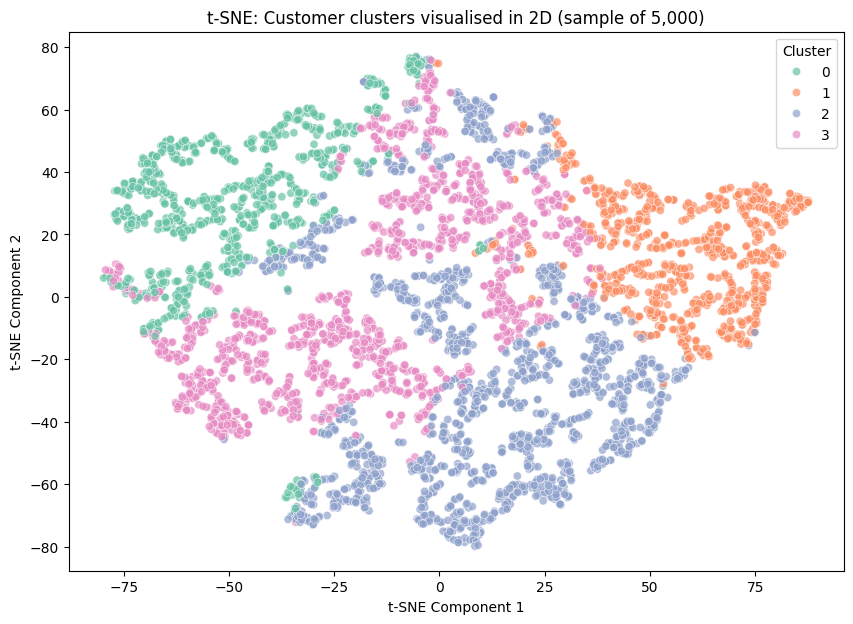

In [ ]:
#from sklearn.manifold import TSNE

# Step 1: Sample 5,000 customers
tsne_sample = df_aggr.sample(n=5000, random_state=42).reset_index(drop=True)

# Step 2: Extract features and scale
features = ['Frequency', 'Recency', 'CLV', 'Avg_Unit_Cost', 'Age']
X_sample = scaler.transform(tsne_sample[features])  # reuse existing scaler

# Step 3: Run t-SNE with lower perplexity for speed
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# Step 4: Create DataFrame for plotting
df_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
df_tsne['cluster'] = tsne_sample['cluster']

# Step 5: Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_tsne, x='Dim1', y='Dim2', hue='cluster', palette='Set2', alpha=0.7)
plt.title('t-SNE: Customer clusters visualised in 2D (sample of 5,000)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()


The t-SNE visualisation using a random sample of 5,000 customers reveals much clearer separation between the clusters compared to the earlier PCA output. Cluster 1 (orange) forms a distinct group on the right-hand side of the plot, while Clusters 0 (green), 2 (blue), and 3 (pink) each form relatively compact and well-defined regions elsewhere in the 2D space.

While a hybrid approach combining PCA with t-SNE can improve performance on large datasets, it remained computationally expensive in this case and offered no meaningful benefit over the sample-based t-SNE approach already implemented. As the visual separation from t-SNE on a 5,000-customer sample was already clear and interpretable, this alternative was not explored further.

## Reflections on PCA vs t-SNE

Both PCA and t-SNE offered valuable visualisations of the customer clusters, but with different strengths. PCA, being a linear method, was much faster and gave a general sense of separation, particularly highlighting Cluster 1 as a distinct group. However, its ability to capture complex, non-linear relationships was limited — leading to some overlap between clusters in the 2D projection.

In contrast, t-SNE provided a far more structured and expressive view of the clusters. Even with a reduced sample size of 5,000 customers, the separation between clusters was noticeably cleaner, and local groupings were more coherent. This made t-SNE a more effective tool for understanding how K-means segmented the customer base, especially when exploring subtle patterns in behaviour.

Although t-SNE is computationally slower, it proved worthwhile here. For larger datasets, a hybrid PCA → t-SNE approach would likely be optimal, reducing dimensions while preserving meaningful structure. Overall, t-SNE gave the most intuitive and informative cluster view, reinforcing confidence in the segmentation results.

# Summary of approach and conclusions

This project followed a structured approach to customer segmentation, starting with data cleaning and exploratory analysis. Numerical columns were cleaned, outliers were identified using the IQR method, and five key features were engineered to support segmentation: Frequency, Recency, CLV, Average Unit Cost, and Age. The dataset was then aggregated to one row per customer and scaled to support distance-based clustering.

Three clustering methods were evaluated: K-means, the Elbow method, and Hierarchical clustering. All methods pointed toward a 4-cluster solution, which was selected as the most appropriate. K-means was chosen as the final clustering model due to its interpretability, performance, and alignment with the other methods.

Boxplots showed that each cluster represented distinct customer behaviours, from high-value active customers to low-engagement, at-risk groups. Dimensionality reduction techniques were applied to visualise the clusters. PCA gave a basic overview, but t-SNE provided a much clearer separation between groups, even with a reduced sample size.

In conclusion, K-means clustering, supported by t-SNE visualisation, proved to be the most effective combination for identifying actionable customer segments in this dataset.

# Reflect

This project required careful planning to balance data preparation, feature engineering, and model selection. Instead of rushing to clustering, I prioritised clean feature construction at the row level before aggregating to customer level. When selecting the number of clusters, I compared three independent methods and deliberately chose k = 4 despite the slightly higher silhouette score at k = 5 — a trade-off favouring model simplicity and interpretability. Each step was informed by evidence and business context, rather than automation, ensuring the segmentation was both robust and actionable.

### Reference:
SAS, 2024. CUSTOMERS_CLEAN [Data set]. SAS. Last revised on 15 December 2021. [Accessed 20 February 2024].